# Cuve fitting
Curve fitting or Data fitting is the process of finding a mathematical expression that describes a given data set.
In general, data fitting, or curve fitting can be devided into *local* and *global* fits, with a *global* fitting refering to a single function in the independant variable that fully discribes the data that is being fit. A *local* fitting refers to a function that only locally describes the data set being fit in a few points. 

<img src="https://ipython-books.github.io/pages/chapter09_numoptim/03_curvefitting_files/03_curvefitting_14_0.png" width="400" height="400" />


# Interpolation: Lagrange Interpolation
One method of finding a expression for a given data set is the Lagrange interpolation technique. This method involves approximating a given data set locally by an $n$-*th* order polynomial $f(x)$, with $$n=N-1,$$ where $N$ is the number of data points in the given data set.

We have that:

$$
\begin{equation}
f(x)=y_{1}\lambda_{1}+y_{2}\lambda_{2}+...+y_{N}\lambda_{N},
\label{Lag}
\tag{1}
\end{equation}
$$

with:

$$
\begin{equation}
\lambda_{i}=\Pi^{n}_{j=1, j\neq i}\frac{x-x_{j}}{x_{i}-x_{j}}.
\label{Lam}
\tag{2}
\end{equation}
$$



One short comming of interpiolation techniques such as Lagrange Interpolation is that though the technique produces an expression that acurately fits all the data points in the given data set when applied to large data sets, the resulting expression can be very complex and oscillate between the various data points that can produce unphysical descriptions of the data, as can be seen in the left most graph in the following image:

<img src="https://github.com/PieterVDMerwe/Computational-rescources/blob/master/Interpolation.png?raw=true" width="400" height="400" />

This problem is further amplified if there are errors on the data in the data set.

# Curve fitting:Cubic Spline
One possible solution to the the previously stated short comming of the interpolation techniques, is to break up the data set into small segments that can be interpolated locally (with each $i$-th segment containing four of the points in the data set). 

Let $f(x)$ be the exact expression that describes the data set and $f_{i}(x)$ the approximate values given in th data set. The Cubic Splines method is then described by the following equations: 

$$
\begin{equation}
f(x) \approx f_{i}(x),
\label{Spline1}
\tag{3}
\end{equation}
$$

on the interval $x_{i}\leq x \leq x_{i+1}$, where this interval represents every four data points in the data set and 

$$
\begin{equation}
f_{i}(x)=y_{i}+\sum^{3}_{n=1}\frac{f^{(n)}_{i}(x-x_{i})^{n}}{n!}.
\label{Spline2}
\tag{4}
\end{equation}
$$

In equation $\eqref{Spline2}$ $y_{i}=f(x_{i})$ and $f^{(n)}=\frac{d^{n}f}{dx^{n}}$. To ensure that there are no discontinuity in the expression we require that :
$$
\begin{equation}
f_{i}(x_{i+1})=f_{i+1}(x_{i+1}),\ \ \ \ \ i=[1,N-1].
\label{Spline3}
\tag{5}
\end{equation}
$$


To further improve upon this, we can require that the first, second and third derivatives of consecutive segments be equal on the boundry between segments:

$$
\begin{equation}
f^{(n)}_{i}(x_{i+1})=f^{(n)}_{i+1}(x_{i+1}),\ \ \ \ n=1,2,3.
\label{Spline4}
\tag{6}
\end{equation}
$$

The derivative to each order is calculated numerically using the finite difference method from the derivatives of on order down:

$$
\begin{equation}
f^{(n+1)}_{i}=\frac{f^{(n)}_{i+1}-f^{(n)}_{i}}{x_{i+1}-x_{i}},\ \ \ n=0,1,2.
\label{Spline5}
\tag{7}
\end{equation}
$$

At the boundaries of the data set, we can use the forward and backward methods to calculate the derivatives in at each boundary, or set the derivatives equal to zero, which is known as a natural spline or clamped spline.

Solving these sets of equations for each segment, we can get a piecewise expression for the data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import interpolate as intr

def cubicSpline(x,y):
    h = [];
    for i in range(len(x)-1):
        h.append(x[i+1]-x[i]);
    alpha = [];
    for i in range(1,len(x)-1):
        alpha.append((3.0/h[i])*(y[i+1]-y[i])-(3.0/h[i-1])*(y[i]-y[i-1]));
    l=[1.0];
    mu=[0.0];
    z=[0.0];
    for i in range(1,len(x)-1):
        l.append(2.0*(x[i+1]-x[i-1])-h[i-1]*mu[i-1]);
        mu.append(h[i]/l[i]);
        z.append((alpha[i-1]-h[i-1]*z[i-1])/l[i]);
    l.append(1.0);
    z.append(0.0);
    c = np.zeros(len(x));
    b = np.zeros(len(x));
    d = np.zeros(len(x));
    for i in range(1,len(x)):
        j = len(x)-1-i;
        c[j]=z[j]-mu[j]*c[j+1];
        b[j]=(y[j+1]-y[j])/h[j] - h[j]*(c[j+1]+2.0*c[j])/3.0;
        d[j]=(c[j+1]-c[j])/(3.0*h[j]);
    return y, b, c, d;

def genFunc(xval,x,y,b,c,d):
    i = 0;
    while (xval > x[i])and(i<len(x)-1):
        i = i+1;
    return y[i]+b[i]*(xval-x[i])+c[i]*(xval-x[i])**(2.0)+d[i]*(xval-x[i])**(3.0);

def f(x,n):
    return 1.0*np.exp(-1.0*(x-3.3)**2)+n*np.asanyarray(random.sample(range(0,1000),len(x)));
def scif(x,xp,yp):
    tck = intr.splrep(xp,yp);
    return intr.splev(x, tck);

def displayFit(noise,ax):
    x = np.arange(0.0,7.0,0.1);
    y = f(x,noise);

    a,b,c,d = cubicSpline(x,y);

    xx = np.arange(1.0,5.0,0.1);
    yy = [];
    yyy = [];
    for i in range(len(xx)):
        yy.append(genFunc(xx[i],x,a,b,c,d));
        yyy.append(scif(xx[i],x,y));

    ax.plot(xx,yyy,label='scipy');
    ax.plot(xx,yy,label='simple');
    ax.scatter(x,y,label='original values+noise');
    ax.legend(ncol=1);
    ax.set_xlabel('x');
    ax.set_ylabel('y');
    #plt.savefig('cubic_spline'+str(noise)+'.png');
    #plt.show();
    return x, y, xx, yyy;

fig = plt.figure(figsize=(20,6));
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
    
#, x2, y2 
x, y, x2, y2 = displayFit(0.0,ax1);
x, y, x2, y2 = displayFit(0.0001,ax2);
fig.savefig('cubic_spline.png');
plt.show();




<Figure size 2000x600 with 2 Axes>

# Example
In the following figure I have used a natural simple cubic spline program that generates a piecewise expression for a given data set and then used it to plot the expression for arbitrary x values. The program is, however, very sensitive to noise, as can be clearly seen in the right image. 

The orange line shows the scipy cubic spline fiting method, which fits the given data quite well and is much less sensitive to noise. The Scipy method does not use a natural spline variation and also uses different and more accurate methods to solve the cubic slpine equations for the various constantants.
<img src="https://github.com/PieterVDMerwe/Unit_8/blob/master/cubic_spline.png?raw=true" width="800" height="200" />

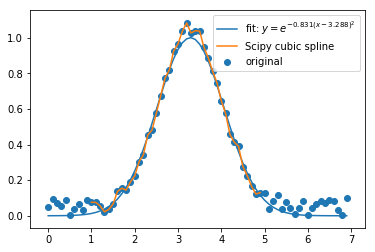

In [2]:
import scipy.optimize as scio
def func(x, b,c):
    return np.exp(b*((x-c)**(2.0)));



popt, pcov = scio.curve_fit(func,x,y);
plt.plot(x,func(x,popt[0],popt[1]),label=r"fit: $y=e^{%5.3f(x-%5.3f)^{2}}$"%tuple(popt));
plt.scatter(x,y,label='original');
plt.plot(x2,y2,label='Scipy cubic spline');
plt.legend();
plt.savefig('comparison.png');
plt.show();

# Other methods
Other methods of curve fitting, involve finding an expression that approximately fits the trend of the given data set. Such methods rely on determining the goodness of the fit using statisticalmethods such as the $\chi^{2}-$method or monte-carlo methods. These methods, are much less sensative to noise in the data set, but most require prior knowledge of the data set.

The figure shows a comparison between a cubic spline interpolation and and fitting a predetermined expresion for unkown parameters to a given data set with noise included.


<img src="https://github.com/PieterVDMerwe/Unit_8/blob/master/comparison.png?raw=true" width="400" height="400" />